In [1]:
from ISR.models import RRDN
from ISR.models import Discriminator
from ISR.models import Cut_VGG19
from ISR.utils.datahandler import DataHandler

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os

from skimage.measure import compare_ssim, compare_mse, compare_psnr
from skvideo.measure import niqe

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Using TensorFlow backend.


In [2]:
lr_patch_size = 40
layers_to_extract = [5, 9]
scale = 2
hr_patch_size = lr_patch_size * scale

rrdn  = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_patch_size)
mae_rrdn  = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64, 'T':10, 'x':scale}, patch_size=lr_patch_size)
f_ext = Cut_VGG19(patch_size=hr_patch_size, layers_to_extract=layers_to_extract)
discr = Discriminator(patch_size=hr_patch_size, kernel_size=3)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
lr_dir = '/home/canrobins13/landsat_8/LR_2x/valid'
hr_dir = '/home/canrobins13/landsat_8/HR_2x/valid'

data_handler = DataHandler(
  lr_dir=lr_dir,
  hr_dir=hr_dir,
  patch_size=lr_patch_size,
  scale=scale,
)

In [4]:
rrdn.model.load_weights('rrdn-C4-D3-G64-G064-T10-x2_best-val_generator_PSNR_epoch243.hdf5')
mae_rrdn.model.load_weights('rrdn-C4-D3-G64-G064-T10-x2_best-val_generator_PSNR_Y_epoch189.hdf5')

In [5]:
batch = data_handler.get_batch(batch_size=32, flatness=0.0)
sr = rrdn.model.predict(batch['lr']).clip(0, 1)
sr_mae = mae_rrdn.model.predict(batch['lr']).clip(0, 1)

In [6]:
batch_size = batch['hr'].shape[0]
psnr, ssim, mse = np.zeros(batch_size), np.zeros(batch_size), np.zeros(batch_size)

for i in range(batch_size):
    hr = batch['hr'][i]
    psnr[i] = compare_psnr(hr, sr[i], data_range=1.0)
    ssim[i] = compare_ssim(hr, sr[i], data_range=1.0, multichannel=True)
    mse[i] = compare_mse(hr, sr[i])

In [7]:
print('mse:', mse.mean())
print('psnr:', psnr.mean())
print('ssim:', ssim.mean())

mse: 1.3247431872611637e-05
psnr: 49.362229175379184
ssim: 0.9894508344181752


In [8]:
psnr, ssim, mse = np.zeros(batch_size), np.zeros(batch_size), np.zeros(batch_size)

for i in range(batch_size):
    hr = batch['hr'][i]
    lr = batch['lr'][i]
    sr_ = np.array(Image.fromarray(np.uint8(lr*255)).resize((80, 80), resample=Image.BILINEAR))/255.0
    psnr[i] = compare_psnr(hr, sr_, data_range=1.0)
    ssim[i] = compare_ssim(hr, sr_, data_range=1.0, multichannel=True)
    mse[i] = compare_mse(hr, sr_)

In [9]:
print('mse:', mse.mean())
print('psnr:', psnr.mean())
print('ssim:', ssim.mean())

mse: 1.0065439574522621e-05
psnr: 50.636697942031994
ssim: 0.9916097337777277


In [10]:
def adjust_gamma(img, gamma=1.0):
  img = (img * 255).astype(np.uint8)
  table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255
    for i in np.arange(0, 256)]).astype(np.uint8)

  return cv2.LUT(img, table)

In [11]:
def display_ims(sr, lr, hr, gamma=1.0):
  _, axs = plt.subplots(1, 3, figsize=(20, 12))
  axs = axs.flatten()

  print('\t\t Super Resolution \t\t\t\t Low Resolution \t\t\t\t High Resolution')
  axs[0].imshow(adjust_gamma(sr, gamma=gamma))
  axs[1].imshow(adjust_gamma(lr, gamma=gamma))
  axs[2].imshow(adjust_gamma(hr, gamma=gamma))
  plt.show()

In [12]:
def get_ims(model=rrdn, img_name='img_1.png', x1=400, y1=400, dx=100, dy=100, scale=4):
  lr = plt.imread(os.path.join(lr_dir, img_name))[x1:x1+dx, y1:y1+dx, :]
  hr = plt.imread(os.path.join(hr_dir, img_name))[x1*scale : (x1+dx)*scale, y1*scale : (y1+dx)*scale, :]
  sr = (model.predict(lr * 255, by_patch_of_size=36) / 255.0)
  return sr, lr, hr

In [13]:
i = 27
sr, lr, hr = get_ims(model=rrdn, img_name='img_{}.png'.format(i), x1=1000, y1=1000, dx=300, dy=300, scale=scale)
sr_mae, _, _ = get_ims(model=mae_rrdn, img_name='img_{}.png'.format(i), x1=1000, y1=1000, dx=300, dy=300, scale=scale)

In [14]:
sr_bilinear = np.array(Image.fromarray(np.uint8(lr*255)).resize((hr.shape[1], hr.shape[0]), resample=Image.BILINEAR))/255.0

		 Bilinear Upsampling


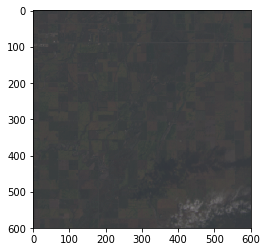

In [15]:
print('\t\t Bilinear Upsampling')
plt.imsave('bilinear_upsampling_{}.png'.format(i), adjust_gamma(sr_bilinear, gamma=1.5))
plt.imshow(adjust_gamma(sr_bilinear, gamma=1.5))

		 SR GAN


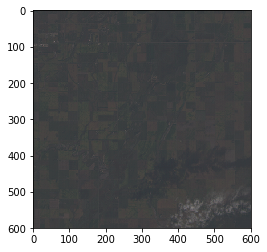

In [16]:
print('\t\t SR GAN')
plt.imsave('sr_gan_{}.png'.format(i), adjust_gamma(sr, gamma=1.5))
plt.imshow(adjust_gamma(sr, gamma=1.5))

		 SR MAE


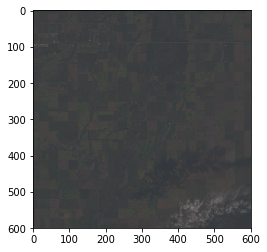

In [17]:
print('\t\t SR MAE')
plt.imsave('sr_mae_{}.png'.format(i), adjust_gamma(sr_mae, gamma=1.5))
plt.imshow(adjust_gamma(sr_mae, gamma=1.5))

		 LR


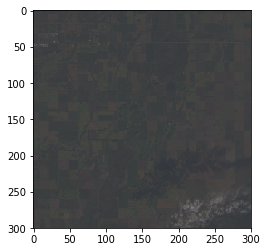

In [18]:
print('\t\t LR')
plt.imsave('lr_{}.png'.format(i), adjust_gamma(lr, gamma=1.5))
plt.imshow(adjust_gamma(lr, gamma=1.5))

		 HR


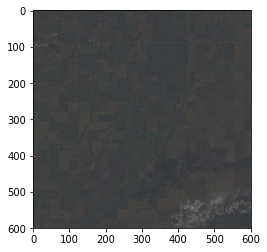

In [19]:
print('\t\t HR')
plt.imsave('hr{}.png'.format(i), adjust_gamma(hr, gamma=1.5))
plt.imshow(adjust_gamma(hr, gamma=1.5))

In [22]:
niqe(sr.mean(-1))

array([21.782051], dtype=float32)

In [ ]:
display_ims(*ims, gamma=1.4)